# Ornstein-Ulhenbeck process

An Introduction to Random Matrix exercice 4.3.9 p263 (Anderson Guionnet Zeitouni) [cupbook]

# 1. Random matrix simulation

In [1]:
%pylab inline
from numpy.matlib import repmat
import plotly.graph_objs as go
import plotly.offline
from matplotlib.gridspec import GridSpec
import sys
sys.path.append('../dyson_brownian_motion/')
from plot_tools import adjust_spines, sc_law, plot_dpp, plot_traj_with_histo, plot_traj_with_histo_sclaw
plt.style.use('classic')
plt.rc('figure',facecolor='w')
plt.rc('font', size=10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def gue(dim, beta, normalization=False):
    """ GUE matrix used to generated the Hermitian Brownian motion as describe in agz
            parameters :
                - beta=1 for GOE et 2 for GUE
                - normalization=True if division by 1/sqrt(N) is wanted (in agz for example)
            """
    B = np.random.randn(dim, dim)
    B_tild = np.random.randn(dim, dim)
    diag = (2/(beta))**0.5 * np.diag(np.diag(B))
    triu = (1/(beta))**0.5 * (np.triu(B,1) + 1j*(beta-1)*np.triu(B_tild,1))
    H = np.zeros((dim,dim)) + diag + triu + np.conjugate(triu).T
    if normalization:
        H_return = (1/(dim**0.5))*H
    else:
        H_return = H
    return H_return

In [3]:
class ornstein_ulhenbeck:
    def __init__(self, n_traj, n_samples, tf, M):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf = tf
        self.dt = self.tf/n_samples
        init_mat = gue(self.n_traj, beta=2, normalization=True)
        #init_mat = np.zeros((self.n_traj, self.n_traj))
        self.matrices = [ init_mat]
        self.generate()
        self.eigen_values = [ sorted(np.linalg.eigvalsh(init_mat),reverse=True) ]
        self.diag()

    def generate(self):
        for sample in range(1, self.n_samples+1): 
            self.matrices.append(self.matrices[sample-1] + \
                gue(self.n_traj, beta=2, normalization=True)*(self.dt)**0.5 - 0.5*self.matrices[sample-1]*self.dt)

    def diag(self):
        for sample in range(1, self.n_samples+1):
            self.eigen_values.append( sorted(np.linalg.eigvalsh(self.matrices[sample]), reverse=True) )

In [4]:
test_random_matrix = ornstein_ulhenbeck(70, 300, 1, 3)

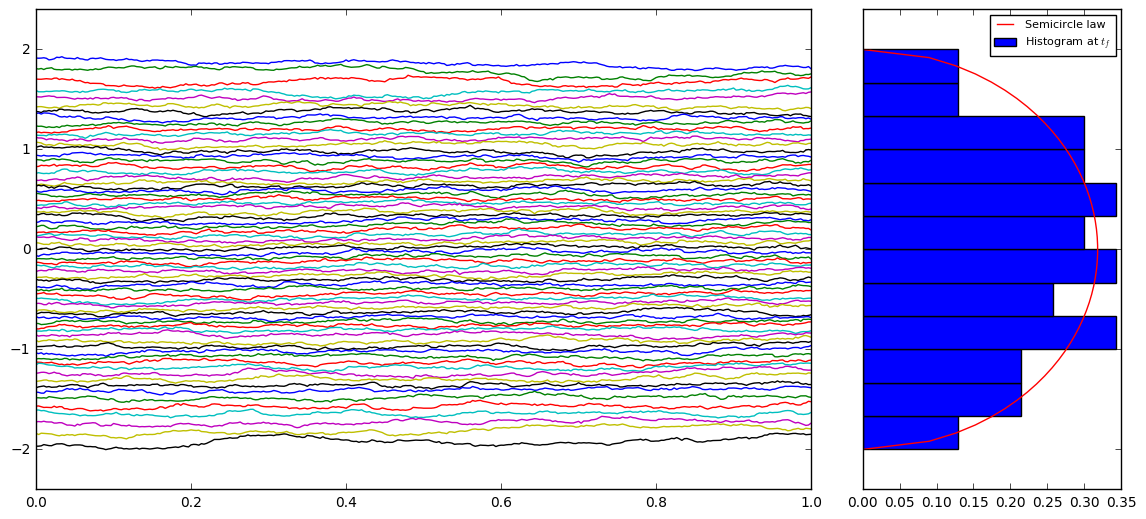

In [5]:
plot_traj_with_histo_sclaw(test_random_matrix, R=2, title='./plot/ornstein_ulhenbeck_histo.png', n_bins=12)

## 2. Stochastic differential equation simulation

In [6]:
class orn_ulh_eigen_values:
    def __init__(self, n_traj, n_samples, tf):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf=tf
        self.dt = tf/n_samples
        self.eigen_values = np.zeros((self.n_samples+1, self.n_traj)) 
        self.initialisation()
        self.generate()

    def initialisation(self):
        #self.eigen_values[0] = np.linspace(1, 0.01, num=self.n_traj)
        init_mat = gue(self.n_traj, beta=2, normalization=True)
        self.eigen_values[0] = sorted(np.linalg.eigvalsh(init_mat),reverse=True)
        return self.eigen_values

    def generate(self):
        for sample in range(1, self.n_samples+1):
            
            for i in range(self.n_traj):

                lbda_i = self.eigen_values[sample-1][i]
                eigen_values_list = [lbda for lbda in list(self.eigen_values[sample-1]) if lbda != lbda_i]

                sum_term = sum ([ (1/(lbda_i - lbda_k)) for lbda_k in eigen_values_list ])
                # print("sumterm", sum_term)

                W = (self.dt)**(0.5) * np.random.randn()
                self.eigen_values[sample][i] = self.eigen_values[sample-1][i] + \
                                                W *(1/self.n_traj)**(0.5) + \
                                                 (1/self.n_traj)*sum_term * self.dt - \
                                                 0.5*self.eigen_values[sample-1][i] * self.dt
                # print("eigen:", self.eigen_values[sample+1][i])

        return self.eigen_values

    def plot(self):
        data = []
        for traj in range(self.n_traj):
            traj_trace = go.Scatter(
                x=self.dt*np.array(range(self.n_samples)),
                y=self.eigen_values.T[traj],
                mode='lines')
            data.append(traj_trace)
        layout = go.Layout(showlegend=False)
        fig = go.Figure(data=data, layout=layout)
        plotly.offline.init_notebook_mode()
        plotly.offline.iplot(fig)

In [7]:
n_traj=50
n_samples=3000
test_eigen_values = orn_ulh_eigen_values(n_traj, n_samples, 1)
#test_eigen_values.plot()

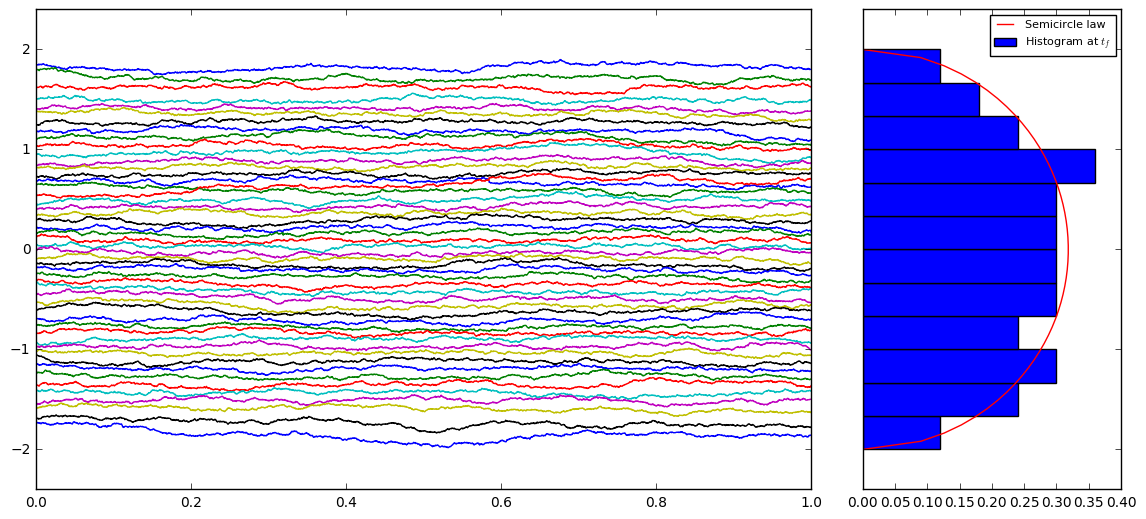

In [8]:
plot_traj_with_histo_sclaw(test_eigen_values, R=2, title='./plot/orn_ulh_eigenvalues_histo_'+str(n_traj)+'_'+str(n_samples)+'.png', n_bins=12)